# Train/Dev/Test split of AotM-2011 songs in setting I & II

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from scipy.optimize import check_grad
from scipy.sparse import lil_matrix, issparse
from collections import Counter
import itertools as itt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from BinaryRelevance import BinaryRelevance
#from PClassificationMLC import PClassificationMLC
from PCMLC import PCMLC as PClassificationMLC
from PCMLC import obj_pclassification
from evaluate import calc_F1, calc_precisionK, calc_rank, f1_score_nowarn, evalPred

In [3]:
data_dir = 'data/aotm-2011'
#faotm = os.path.join(data_dir, 'aotm2011-subset.pkl')
faotm = os.path.join(data_dir, 'aotm2011-user-playlist.pkl')
#ffeature = 'data/msd/songID2Features.pkl.gz'
ffeature = 'data/msd/song2feature.pkl.gz'
fgenre = 'data/msd/song2genre.pkl'

## Load playlists

Load playlists.

In [4]:
user_playlists = pkl.load(open(faotm, 'rb'))

In [5]:
all_users = sorted(user_playlists.keys())

In [6]:
all_playlists = [(pl, u) for u in all_users for pl in user_playlists[u]]

In [7]:
print('#user    : {:,}'.format(len(all_users)))
print('#playlist: {:,}'.format(len(all_playlists)))

#user    : 14,182
#playlist: 84,710


In [8]:
pl_lengths = [len(pl) for u in all_users for pl in user_playlists[u]]
#plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

Average playlist length: 10.1


## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [9]:
song2feature = pkl.load(gzip.open(ffeature, 'rb'))

## Split songs for setting I

Split songs (70/10/20 train/dev/test split) the latest released (year) songs are in dev and test set.

In [10]:
all_songs = sorted([(sid, song2feature[sid][-1]) for sid in \
                    {s for u in all_users for pl in user_playlists[u] for s in pl}], key=lambda x: x[1])
print('{:,}'.format(len(all_songs)))

114,428


In [11]:
pkl.dump(all_songs, gzip.open(os.path.join(data_dir, 'all_songs.pkl.gz'), 'wb'))

In [12]:
nsong_dev_test = int(len(all_songs) * 0.3)
train_song_set = all_songs[nsong_dev_test:]

# shuffle songs in dev and test set
np.random.seed(123456789)
dev_test_ix = np.random.permutation(np.arange(nsong_dev_test))
nsong_dev = int(len(all_songs) * 0.1)
dev_song_set = [all_songs[ix] for ix in dev_test_ix[:nsong_dev]]
test_song_set = [all_songs[ix] for ix in dev_test_ix[nsong_dev:]]

In [13]:
print('#songs in training set: {:,}, average song age: {:.2f} yrs'
      .format(len(train_song_set), np.mean([t[1] for t in train_song_set])))
print('#songs in dev set     : {:,}, average song age: {:.2f} yrs'
      .format(len(dev_song_set),   np.mean([t[1] for t in dev_song_set])))
print('#songs in test set    : {:,}, average song age: {:.2f} yrs'
      .format(len(test_song_set),  np.mean([t[1] for t in test_song_set])))

#songs in training set: 80,100, average song age: 26.05 yrs
#songs in dev set     : 11,442, average song age: 13.39 yrs
#songs in test set    : 22,886, average song age: 13.41 yrs


In [14]:
print('#songs: {:,} | {:,}'.format(len(all_songs), len({s for s in train_song_set + dev_song_set + test_song_set})))

#songs: 114,428 | 114,428


Song popularity.

In [15]:
song2index = {sid: ix for ix, sid in enumerate([t[0] for t in all_songs])}
song_pl_mat = lil_matrix((len(all_songs), len(all_playlists)), dtype=np.int8)
for j in range(len(all_playlists)):
    pl = all_playlists[j][0]
    ind = [song2index[sid] for sid in pl]
    song_pl_mat[ind, j] = 1

In [16]:
song_pop = song_pl_mat.tocsc().sum(axis=1)

In [17]:
song2pop = {sid: song_pop[song2index[sid], 0] for (sid, _) in all_songs}

In [18]:
pkl.dump(song2pop, gzip.open(os.path.join(data_dir, 'song2pop.pkl.gz'), 'wb'))

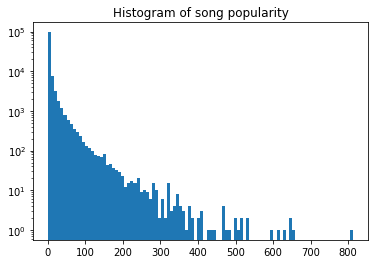

In [19]:
ax = plt.subplot(111)
ax.hist(song_pop, bins=100)
ax.set_yscale('log')
ax.set_title('Histogram of song popularity')
pass

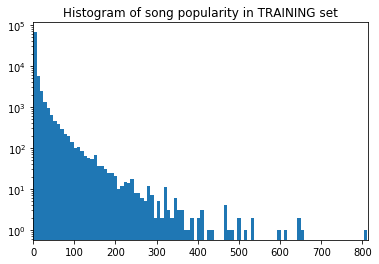

In [20]:
train_song_pop = [song2pop[sid] for (sid, _) in train_song_set]
ax = plt.subplot(111)
ax.hist(train_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
ax.set_title('Histogram of song popularity in TRAINING set')
pass

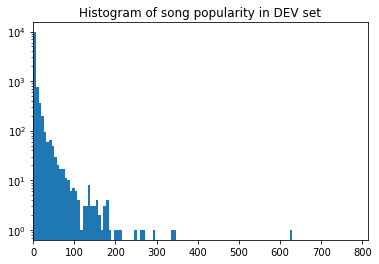

In [21]:
dev_song_pop = [song2pop[sid] for (sid, _) in dev_song_set]
ax = plt.subplot(111)
ax.hist(dev_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
ax.set_title('Histogram of song popularity in DEV set')
pass

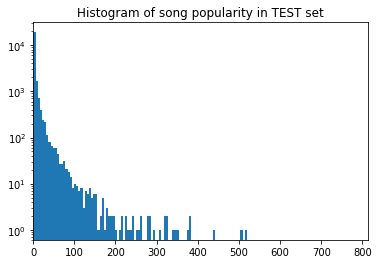

In [22]:
test_song_pop = [song2pop[sid] for (sid, _) in test_song_set]
ax = plt.subplot(111)
ax.hist(test_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
ax.set_title('Histogram of song popularity in TEST set')
pass

## Load genres

Song genres from [MSD Allmusic Genre Dataset (Top MAGD)](http://www.ifs.tuwien.ac.at/mir/msd/TopMAGD.html) and [tagtraum](http://www.tagtraum.com/msd_genre_datasets.html).

In [23]:
song2genre = pkl.load(open(fgenre, 'rb'))

Check if all songs have genre info.

In [24]:
print('#songs missing genre: {:,}'.format(len(all_songs) - np.sum([sid in song2genre for (sid, _) in all_songs])))

#songs missing genre: 33,907


## Create song-playlist matrix

Songs as rows, playlists as columns.

In [25]:
def gen_dataset(playlists, song2feature, song2genre, train_song_set, dev_song_set=[], test_song_set=[]):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - train_song_set: a list of songIDs in training set
        - dev_song_set: a list of songIDs in dev set
        - test_song_set: a list of songIDs in test set
        - song2feature: dictionary that maps songIDs to features from MSD
        - song2genre: dictionary that maps songIDs to genre
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """ 
    song_set = train_song_set + dev_song_set + test_song_set
    N = len(song_set)
    K = len(playlists)
    
    genre_set = sorted({v for v in song2genre.values()})
    genre2index = {genre: ix for ix, genre in enumerate(genre_set)}
    
    def onehot_genre(songID):
        """
        One-hot encoding of genres.
        Data imputation: 
            - one extra entry for songs without genre info
            - mean imputation
            - sampling from the distribution of genre popularity
        """
        num = len(genre_set) # + 1
        vec = np.zeros(num, dtype=np.float)
        if songID in song2genre:
            genre_ix = genre2index[song2genre[songID]]
            vec[genre_ix] = 1
        else:
            vec[:] = np.nan
            #vec[-1] = 1
        return vec
    
    #X = np.array([features_MSD[sid] for sid in song_set])  # without using genre
    #Y = np.zeros((N, K), dtype=np.bool)
    X = np.array([np.concatenate([song2feature[sid], onehot_genre(sid)], axis=-1) for sid in song_set])
    Y = lil_matrix((N, K), dtype=np.bool)
    
    song2index = {sid: ix for ix, sid in enumerate(song_set)}
    for k in range(K):
        pl = playlists[k]
        indices = [song2index[sid] for sid in pl if sid in song2index]
        Y[indices, k] = True
        
    # genre imputation
    genre_ix_start = -len(genre_set)
    genre_nan = np.isnan(X[:, genre_ix_start:])
    genre_mean = np.nansum(X[:, genre_ix_start:], axis=0) / (X.shape[0] - np.sum(genre_nan, axis=0))
    #print(np.nansum(X[:, genre_ix_start:], axis=0))
    #print(genre_set)
    #print(genre_mean)
    for j in range(len(genre_set)):
        X[genre_nan[:,j], j+genre_ix_start] = genre_mean[j]

    #return X, Y
    Y = Y.tocsr()
    
    train_ix = [song2index[sid] for sid in train_song_set]
    X_train = X[train_ix, :]
    Y_train = Y[train_ix, :]
    
    dev_ix = [song2index[sid] for sid in dev_song_set]
    X_dev = X[dev_ix, :]
    Y_dev = Y[dev_ix, :]
    
    test_ix = [song2index[sid] for sid in test_song_set]
    X_test = X[test_ix, :]
    Y_test = Y[test_ix, :]
    
    if len(dev_song_set) > 0:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_dev, Y_dev, X_test, Y_test
        else:
            return X_train, Y_train, X_dev, Y_dev
    else:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_test, Y_test
        else:
            return X_train, Y_train

## Setting I: hold a subset of songs, use all playlists

In [ ]:
pkl_dir = os.path.join(data_dir, 'setting1')
fsongs  = os.path.join(pkl_dir, 'songs_train_dev_test_s1.pkl.gz')
fpl     = os.path.join(pkl_dir, 'playlists_s1.pkl.gz')
fxtrain = os.path.join(pkl_dir, 'X_train.pkl.gz')
fytrain = os.path.join(pkl_dir, 'Y_train.pkl.gz')
fxdev   = os.path.join(pkl_dir, 'X_dev.pkl.gz')
fydev   = os.path.join(pkl_dir, 'Y_dev.pkl.gz')
fxtest  = os.path.join(pkl_dir, 'X_test.pkl.gz')
fytest  = os.path.join(pkl_dir, 'Y_test.pkl.gz')
fadjmat = os.path.join(pkl_dir, 'adjacency_mat.pkl.gz')

In [ ]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = gen_dataset(playlists = [t[0] for t in all_playlists],
                                                             song2feature = song2feature, song2genre = song2genre,
                                                             train_song_set = [t[0] for t in train_song_set],
                                                             dev_song_set   = [t[0] for t in   dev_song_set], 
                                                             test_song_set  = [t[0] for t in  test_song_set])

Feature normalisation.

In [ ]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev   -= X_train_mean
X_dev   /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [ ]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

In [ ]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_dev,   axis=0)))
print(np.mean( np.std(X_dev,   axis=0)) - 1)
print(np.mean(np.mean(X_test,  axis=0)))
print(np.mean( np.std(X_test,  axis=0)) - 1)

In [ ]:
pkl.dump(X_train, gzip.open(fxtrain, 'wb'))
pkl.dump(Y_train, gzip.open(fytrain, 'wb'))
pkl.dump(X_dev,   gzip.open(fxdev,   'wb'))
pkl.dump(Y_dev,   gzip.open(fydev,   'wb'))
pkl.dump(X_test,  gzip.open(fxtest,  'wb'))
pkl.dump(Y_test,  gzip.open(fytest,  'wb'))

In [ ]:
pkl.dump({'train_song_set': train_song_set, 'dev_song_set': dev_song_set, 'test_song_set': test_song_set},
         gzip.open(fsongs, 'wb'))
pkl.dump(all_playlists, gzip.open(fpl, 'wb'))

Build the adjacent matrix of playlists (nodes) for *setting I*, playlists of the same user form a *clique*.

In [ ]:
user_of_playlists = [u for (_, u) in all_playlists]
npl = len(user_of_playlists)
same_user_mat = lil_matrix((npl, npl), dtype=np.bool)
for u in set(user_of_playlists):
    clique = np.where(u == np.array(user_of_playlists, dtype=np.object))[0]
    for x, y in itt.combinations(clique, 2):
        same_user_mat[x, y] = True
        same_user_mat[y, x] = True
same_user_mat = same_user_mat.tocsr()

In [ ]:
#same_user_mat

In [ ]:
pkl.dump(same_user_mat, gzip.open(fadjmat, 'wb'))

## Split playlists for setting II

Split playlists (70/10/20 train/dev/test split) uniformly at random.

In [26]:
train_playlists = []
dev_playlists   = []
test_playlists  = []

In [27]:
npl_test = int(0.2 * len(all_playlists))
npl_dev  = int(0.1 * len(all_playlists))
np.random.seed(123456789)
pl_indices = np.random.permutation(np.arange(len(all_playlists)))
test_playlists  = all_playlists[:npl_test]
dev_playlists   = all_playlists[npl_test:npl_test + npl_dev]
train_playlists = all_playlists[npl_test + npl_dev:]

In [28]:
print('{:30s} {:,}'.format('#playlist in training set:', len(train_playlists)))
print('{:30s} {:,}'.format('#playlist in dev set:', len(dev_playlists)))
print('{:30s} {:,}'.format('#playlist in test set:', len(test_playlists)))

#playlist in training set:     59,297
#playlist in dev set:          8,471
#playlist in test set:         16,942


In [29]:
xmax = np.max([len(pl) for (pl, _) in all_playlists]) + 1

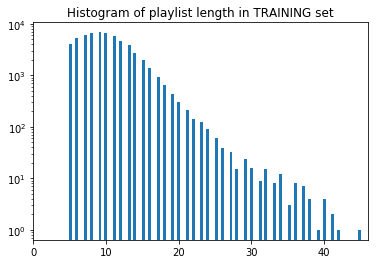

In [30]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in train_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TRAINING set')
pass

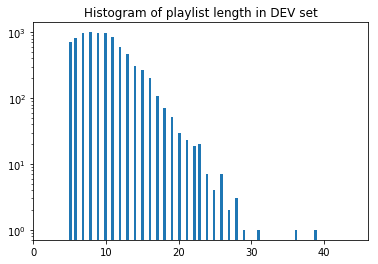

In [31]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in dev_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in DEV set')
pass

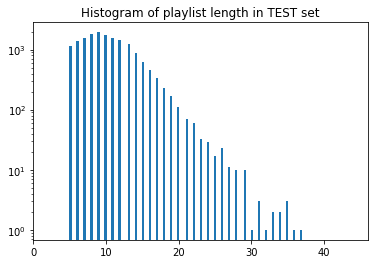

In [32]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in test_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TEST set')
pass

## Setting II: hold the last half of songs in a subset of playlists, use all songs

Hold the last half of songs for playlists in dev and test set.

In [33]:
dev_playlists_obs   = [pl[:-int(len(pl)/2)] for (pl, _) in dev_playlists]
dev_playlists_held  = [pl[-int(len(pl)/2):] for (pl, _) in dev_playlists]
test_playlists_obs  = [pl[:-int(len(pl)/2)] for (pl, _) in test_playlists]
test_playlists_held = [pl[-int(len(pl)/2):] for (pl, _) in test_playlists]

In [34]:
for ix in range(len(dev_playlists)):
    assert np.all(dev_playlists[ix][0]  == dev_playlists_obs[ix]  + dev_playlists_held[ix])
for ix in range(len(test_playlists)):
    assert np.all(test_playlists[ix][0] == test_playlists_obs[ix] + test_playlists_held[ix])

In [35]:
print('DEV  obs: {:,} | DEV  held: {:,} \nTEST obs: {:,} | TeST held: {:,}'.format(
    np.sum([len(ppl) for ppl in dev_playlists_obs]),  np.sum([len(ppl) for ppl in dev_playlists_held]),
    np.sum([len(ppl) for ppl in test_playlists_obs]), np.sum([len(ppl) for ppl in test_playlists_held])))

DEV  obs: 43,461 | DEV  held: 39,026 
TEST obs: 92,329 | TeST held: 83,586


## Setting II: hold a subset of songs in a subset of playlists, use all songs

In [36]:
pkl_dir2 = os.path.join(data_dir, 'setting2')
fpl2     = os.path.join(pkl_dir2, 'playlists_train_dev_test_s2.pkl.gz')
fy2      = os.path.join(pkl_dir2, 'Y.pkl.gz')
fxtrain2 = os.path.join(pkl_dir2, 'X_train.pkl.gz')
fytrain2 = os.path.join(pkl_dir2, 'Y_train.pkl.gz')
fytrndev = os.path.join(pkl_dir2, 'Y_train_dev.pkl.gz')
fydev2   = os.path.join(pkl_dir2, 'PU_dev.pkl.gz')
fytest2  = os.path.join(pkl_dir2, 'PU_test.pkl.gz')
fadjmat2 = os.path.join(pkl_dir2, 'adjacency_mat2.pkl.gz')

In [37]:
X, Y = gen_dataset(playlists = [t[0] for t in train_playlists + dev_playlists + test_playlists],
                   song2feature = song2feature, song2genre = song2genre, 
                   train_song_set = [t[0] for t in all_songs])

In [38]:
X_train = X

In [39]:
dev_cols  = np.arange(len(train_playlists), len(train_playlists) + len(dev_playlists))
test_cols = np.arange(len(train_playlists) + len(dev_playlists), Y.shape[1])
assert len(dev_cols)  == len(dev_playlists)  == len(dev_playlists_obs)
assert len(test_cols) == len(test_playlists) == len(test_playlists_obs)

In [50]:
pkl.dump({'train_playlists': train_playlists, 'dev_playlists': dev_playlists, 'test_playlists': test_playlists,
          'dev_playlists_obs': dev_playlists_obs, 'dev_playlists_held': dev_playlists_held,
          'test_playlists_obs': test_playlists_obs, 'test_playlists_held': test_playlists_held},
          gzip.open(fpl2, 'wb'))

In [40]:
song2index = {sid: ix for ix, sid in enumerate([t[0] for t in all_songs])}

~~Set all entries corresponding to playlists in dev and test set to NaN, except those corresponding to songs that we observed (in dev/test set), this will result in a *huge dense* matrix.~~

In [41]:
#Y_train = Y.tolil(copy=True).astype(np.float)  # note: np.nan is float
#Y_train[:, np.r_[dev_cols, test_cols]] = np.nan   # note this will result in a huge dence matrix

#num_known_dev = 0
#for j in range(len(dev_cols)):
#    rows = [song2index[sid] for sid in dev_playlists_obs[j]]
#    Y_train[rows, dev_cols[j]] = 1
#    num_known_dev += len(rows)

#num_known_test = 0
#for j in range(len(test_cols)):
#    rows = [song2index[sid] for sid in test_playlists_obs[j]]
#    Y_train[rows, test_cols[j]] = 1
#    num_known_test += len(rows)
#Y_train = Y_train.tocsr()

Use dedicated sparse matrices to reprsent what entries are observed in dev and test set.

In [42]:
Y_train = Y[:, :len(train_playlists)].tocsr()
Y_train_dev = Y[:, :len(train_playlists) + len(dev_playlists)].tocsr()

In [43]:
PU_dev  = lil_matrix((len(all_songs), len(dev_playlists)),  dtype=np.bool)
PU_test = lil_matrix((len(all_songs), len(test_playlists)), dtype=np.bool)

num_known_dev = 0
for j in range(len(dev_playlists)):
    if (j+1) % 1000 == 0:
        sys.stdout.write('\r%d / %d' % (j+1, len(dev_playlists))); sys.stdout.flush()
    rows = [song2index[sid] for sid in dev_playlists_obs[j]]
    PU_dev[rows, j] = True
    num_known_dev += len(rows)

num_known_test = 0
for j in range(len(test_playlists)):
    if (j+1) % 1000 == 0:
        sys.stdout.write('\r%d / %d' % (j+1, len(test_playlists))); sys.stdout.flush()
    rows = [song2index[sid] for sid in test_playlists_obs[j]]
    PU_test[rows, j] = True
    num_known_test += len(rows)

PU_dev  = PU_dev.tocsr()
PU_test = PU_test.tocsr()

16000 / 16942

Indices and ground truths for dev and test entries.

In [44]:
# NOTE: prediction for dev/test is just the complement of PU_dev/PU_test

#Y_dev_gtlist  = [Y[ix] for ix in Y_dev_indices]
#Y_test_gtlist = [Y[ix] for ix in Y_test_indices]

In [45]:
print('#unknown entries in DEV  set: {:15,d} | {:15,d} \n#unknown entries in TEST set: {:15,d} | {:15,d}'.format(
    np.prod(PU_dev.shape)  - PU_dev.sum(),  len(dev_playlists)  * len(all_songs) - num_known_dev,
    np.prod(PU_test.shape) - PU_test.sum(), len(test_playlists) * len(all_songs) - num_known_test))

#unknown entries in DEV  set:     969,276,127 |     969,276,127 
#unknown entries in TEST set:   1,938,546,847 |   1,938,546,847


In [46]:
print('#unknown entries in Setting I: {:,}'.format((len(dev_song_set) + len(test_song_set)) * Y.shape[1]))

#unknown entries in Setting I: 2,907,924,880


Feature normalisation.

In [47]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std

In [48]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)

1.0610901839450387e-14
-0.0184462278318972


In [49]:
print('All  : %s' % str(Y.shape))
print('Train: %s, %s' % (X_train.shape, Y_train.shape))
print('Dev  : %s' % str(PU_dev.shape))
print('Test : %s' % str(PU_test.shape))

All  : (114428, 84710)
Train: (114428, 217), (114428, 59297)
Dev  : (114428, 8471)
Test : (114428, 16942)


In [51]:
pkl.dump(X_train,     gzip.open(fxtrain2, 'wb'))
pkl.dump(Y_train,     gzip.open(fytrain2, 'wb'))
pkl.dump(Y,           gzip.open(fy2, 'wb'))
pkl.dump(Y_train_dev, gzip.open(fytrndev, 'wb'))
pkl.dump(PU_dev,      gzip.open(fydev2, 'wb'))
pkl.dump(PU_test,     gzip.open(fytest2, 'wb'))

Build the adjacent matrix of playlists (nodes) for *setting II*, playlists of the same user form a *clique*.

In [52]:
pl_users = [u for (_, u) in train_playlists + dev_playlists + test_playlists]
npl = len(pl_users)
same_user_mat2 = lil_matrix((npl, npl), dtype=np.bool)
for u in set(pl_users):
    clique = np.where(u == np.array(pl_users, dtype=np.object))[0]
    for x, y in itt.combinations(clique, 2):
        same_user_mat2[x, y] = True
        same_user_mat2[y, x] = True
same_user_mat2 = same_user_mat2.tocsr()

In [53]:
#same_user_mat2

In [54]:
pkl.dump(same_user_mat2, gzip.open(fadjmat2, 'wb'))